In [17]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import SubsetRandomSampler
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, csv_file, img_size=256, num_classes=15, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_size = img_size
        self.num_classes = num_classes
        self.transform = transform
        self.label_transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        label_path = self.data.iloc[idx, 2]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        label = Image.open(label_path).convert('L')
        label = self.label_transform(label)
        label = torch.tensor(np.array(label), dtype=torch.long)
        
        return {'image': image, 'label': label}

# Define transforms (if any additional transforms are needed)
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create datasets and dataloaders
train_dataset = SegmentationDataset('train.csv', transform=image_transform)
val_dataset = SegmentationDataset('val.csv', transform=image_transform)
test_dataset = SegmentationDataset('test.csv', transform=image_transform)

# Calculate the number of samples to include in the subset
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.5 * num_train))

# Randomly shuffle the indices and select the first 30%
np.random.seed(42)  # For reproducibility
np.random.shuffle(indices)
train_indices = indices[:split]

# Create a sampler for the subset
train_sampler = SubsetRandomSampler(train_indices)

train_loader = DataLoader(train_dataset, batch_size=4, sampler=train_sampler)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [18]:
import torch
import torchvision.models.segmentation as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained Deeplabv3 model with ResNet50 backbone
model = models.deeplabv3_resnet50(weights=models.DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = torch.nn.Conv2d(256, 19, kernel_size=(1, 1), stride=(1, 1)) # Assuming 15 classes
model = model.to(device)

print(f'Using device: {device}')

Using device: cuda


In [19]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Training")
    for data in progress_bar:
        images = data['image'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(loader)

def validate(model, loader, device):
    model.eval()
    total_loss = 0
    progress_bar = tqdm(loader, desc="Validation")
    with torch.no_grad():
        for data in progress_bar:
            images = data['image'].to(device)
            labels = data['label'].to(device)
            outputs = model(images)['out']
            loss = F.cross_entropy(outputs, labels)
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(loader)

for epoch in range(10):
    print(f"Epoch {epoch+1}/{10}")
    train_loss = train(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")


Epoch 1/5


Validation: 100%|██████████| 71/71 [00:37<00:00,  1.91it/s, loss=2.74]


Epoch 1, Train Loss: 2.6009133497873944, Val Loss: 2.374659991600144
Epoch 2/5


Validation: 100%|██████████| 71/71 [00:37<00:00,  1.89it/s, loss=2.74]


Epoch 2, Train Loss: 1.9800269921620688, Val Loss: 1.7779517761418517
Epoch 3/5


Validation: 100%|██████████| 71/71 [00:39<00:00,  1.81it/s, loss=1.62]


Epoch 3, Train Loss: 1.6208567380905152, Val Loss: 1.4247110444055477
Epoch 4/5


Validation:  11%|█▏        | 8/71 [00:04<00:38,  1.64it/s, loss=1.4] 


KeyboardInterrupt: 

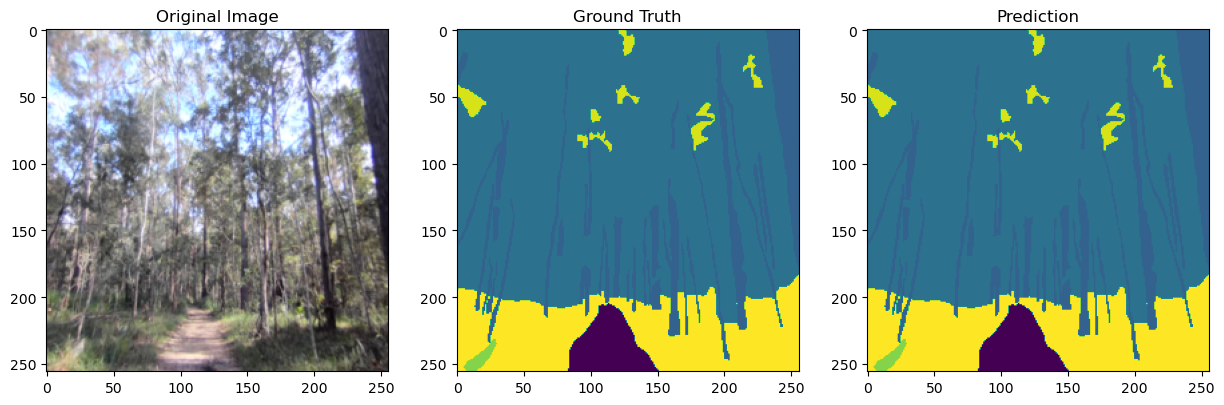

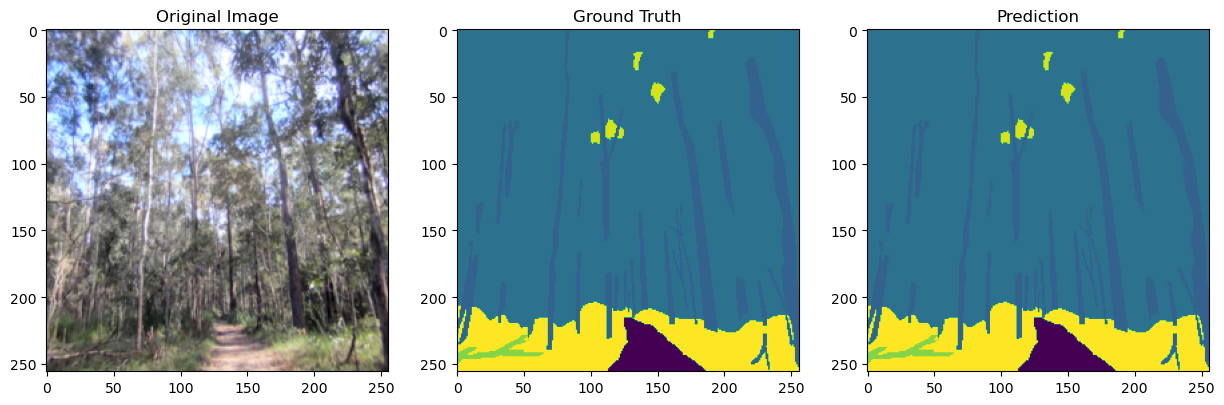

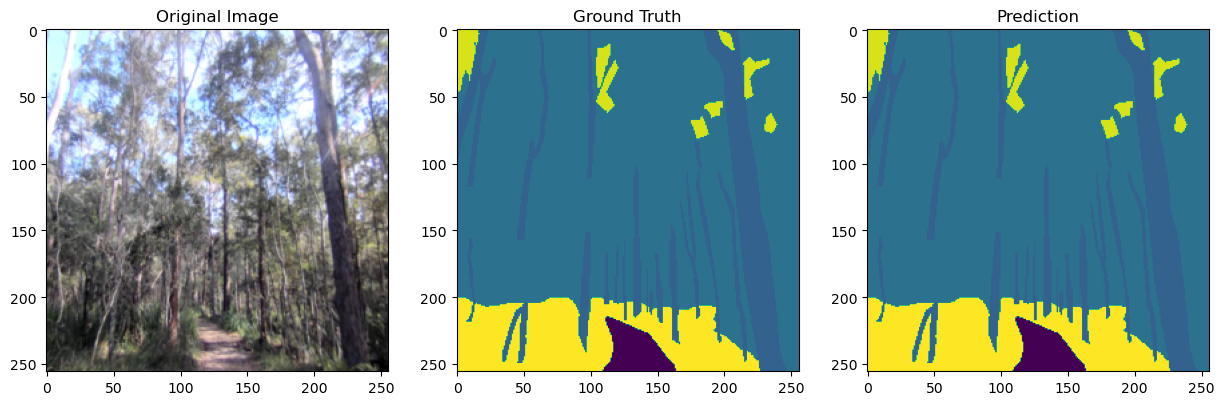

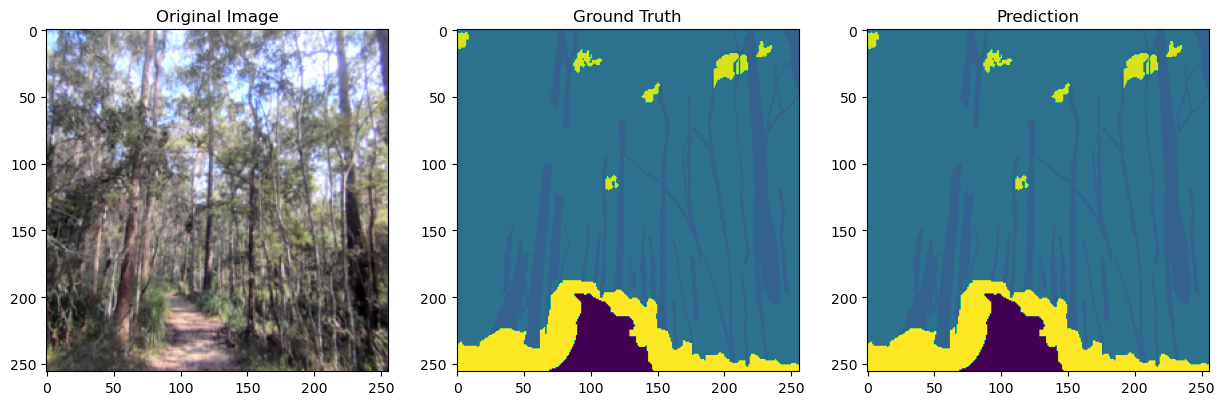

In [20]:
import matplotlib.pyplot as plt

def visualize(image, label, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[1].imshow(label)
    axes[1].set_title('Ground Truth')
    axes[2].imshow(prediction)
    axes[2].set_title('Prediction')
    plt.show()

model.eval()
with torch.no_grad():
    for data in test_loader:
        images = data['image'].to(device)
        labels = data['label'].cpu().numpy()
        # outputs = model(images)['out'].cpu().numpy()
        for i in range(len(images)):
            image = images[i].cpu().numpy().transpose(1, 2, 0)
            label = labels[i]
            output_probs = outputs[i][0]
            # crf_output = post_process(image, output_probs)
            # prediction = np.argmax(crf_output, axis=0)
            visualize(image, label, output_probs)
        break
